In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Data_Wind.csv')
#df = df[df['ActivePower_value_KWh'] >= 0]

In [4]:
df['index'] = pd.to_datetime(df['index'])

df['year'] = df['index'].dt.year
df['month'] = df['index'].dt.month
df['day'] = df['index'].dt.day
df['hour'] = df['index'].dt.hour
df = df.drop('index', axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58496 entries, 0 to 58495
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   site                      58496 non-null  int64  
 1   ActivePower_value_KWh     58496 non-null  float64
 2   AmbientTemperature_value  58496 non-null  float64
 3   NacelleAngle_value        58496 non-null  float64
 4   RotorSpeed_value          58496 non-null  float64
 5   WindDirection_value       58496 non-null  float64
 6   WindSpeed_value           58429 non-null  float64
 7   year                      58496 non-null  int32  
 8   month                     58496 non-null  int32  
 9   day                       58496 non-null  int32  
 10  hour                      58496 non-null  int32  
dtypes: float64(6), int32(4), int64(1)
memory usage: 4.0 MB


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Se seleccionan las variables de entrada o atributos que utilizamos para hacer predicciones (variables de entrada)
X = df[['WindSpeed_value', 'WindDirection_value', 'RotorSpeed_value', 
          'AmbientTemperature_value', 'NacelleAngle_value', 'hour', 'day', 'month']]

# Rellenar los NaN con la media de cada columna para evitar errores en las predicciones posteriores
X.fillna(X.mean(), inplace=True)


# Se selecciona la variable de salida, en este caso la potencia generada (kWh), para que el modelo sepa lo que tiene que producir
y = df['ActivePower_value_KWh']

# Se dividen los datos en conjuntos de entrenamiento y prueba, en este caso 30% para probar y el resto para entrenar (70%)
# Para la generación de numeros aleatorios he tomado la semilla 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Creamos "model" como el modelo de regresión lineal
model = LinearRegression()

# Se entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Se hacen predicciones con el conjunto de prueba obtenido previamente
y_pred = model.predict(X_test)

# Se evalua el rendimiento del modelo con 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error Cuadrático Medio (MSE): {mse}") # Representa la distancia al cuadrado entre los valores reales y predichos.
print(f"Coeficiente de determinación (R^2): {r2}") # Si se obtiene un 0.60 sería un 60% el cual representa que la variable dependiente es predicha por la variable independiente. 


Error Cuadrático Medio (MSE): 15277905.374151753
Coeficiente de determinación (R^2): 0.5056685461643657


/var/folders/1v/kqncq5z978j2jc6f98w_n3qm0000gn/T/ipykernel_12038/2704370575.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [6]:
X_ker = df[['WindSpeed_value', 'WindDirection_value', 'RotorSpeed_value', 
          'AmbientTemperature_value', 'NacelleAngle_value', 'hour', 'day', 'month']].values

y_ker = df['ActivePower_value_KWh'].values

X_train_ker, X_test_ker, y_train_ker, y_test_ker = train_test_split(X_ker,y_ker,test_size=0.4,random_state=101)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_ker = MinMaxScaler()
scaler_ker.fit(X_train_ker,y_train_ker)

MinMaxScaler()

In [8]:
X_train_ker = scaler_ker.transform(X_train_ker)
X_test_ker = scaler_ker.transform(X_test_ker)
X_train_ker = np.nan_to_num(X_train_ker)  # Reemplaza NaN por 0 y infinitos por valores grandes
y_train_ker = np.nan_to_num(y_train_ker)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [10]:
model = Sequential()

model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse', metrics=['mae'])

In [11]:
X_train_ker = np.array(X_train_ker)
y_train_ker = np.array(y_train_ker)
model.fit(X_train_ker,y_train_ker,epochs=1000,batch_size=35,validation_split=0.3,verbose=0)
#model.fit(X_train_ker,y_train_ker,epochs=100,batch_size=35,validation_data=(X_test_ker, y_test_ker), verbose=1)

___
### Diferencia entre `loss` y `val_loss`

- **`loss`**: Es la pérdida calculada en el **conjunto de entrenamiento** al final de cada época. Este valor indica qué tan bien el modelo está ajustando los datos de entrenamiento. Un `loss` bajo sugiere que el modelo se ajusta bien al conjunto de entrenamiento.

- **`val_loss`**: Es la pérdida calculada en el **conjunto de validación** al final de cada época. El conjunto de validación no se utiliza para ajustar los pesos del modelo durante el entrenamiento, sino que actúa como una medida de rendimiento en datos no vistos. Un `val_loss` bajo indica que el modelo generaliza bien en datos nuevos.


In [12]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
#recall = model.history.history['recall']

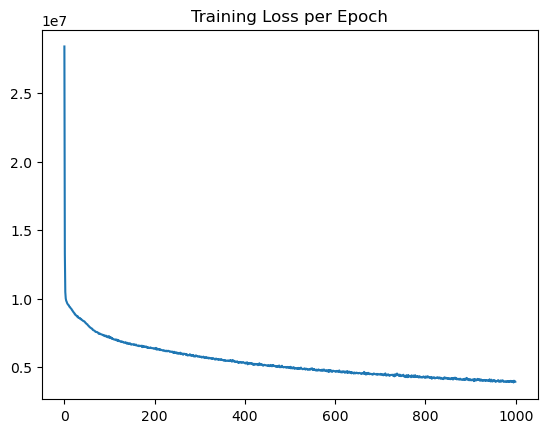

In [13]:
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch");
#El "Training Loss per Epoch" muestra cuánto error comete el modelo en cada época.

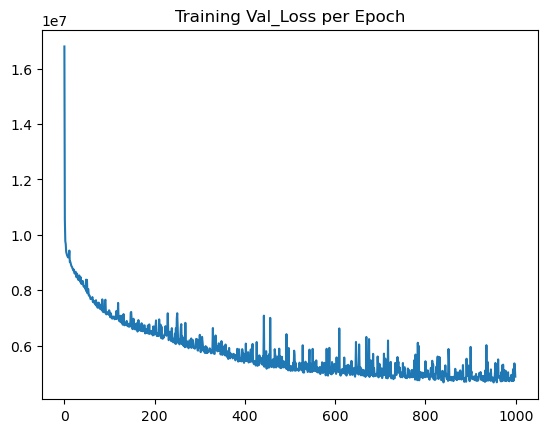

In [14]:
sns.lineplot(x=range(len(val_loss)),y=val_loss)
plt.title("Training Val_Loss per Epoch");

In [15]:
# Rellenar NaN con la media de cada columna
X_train_ker = np.where(np.isnan(X_train_ker), np.nanmean(X_train_ker, axis=0), X_train_ker)
X_test_ker = np.where(np.isnan(X_test_ker), np.nanmean(X_test_ker, axis=0), X_test_ker)

# Obtener las predicciones
y_pred_ker = model.predict(X_test_ker)

# Calcular MSE, MAE y R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_ker, y_pred_ker)
mae = mean_absolute_error(y_test_ker, y_pred_ker)
r2 = r2_score(y_test_ker, y_pred_ker)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")


732/732 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
Mean Squared Error (MSE): 4755040.52
Mean Absolute Error (MAE): 1348.46
R² Score: 0.85


____

## 10 Epoch

Mean Squared Error (MSE): 8711740.36 

Mean Absolute Error (MAE): 1935.03 

R² Score: 0.72 

## 100 Epoch

Mean Squared Error (MSE): 6791229.79

Mean Absolute Error (MAE): 1649.85

R² Score: 0.78

## 250 Epoch 

Mean Squared Error (MSE): 5865138.41

Mean Absolute Error (MAE): 1468.84

R² Score: 0.81

## 500 Epoch

Mean Squared Error (MSE): 5252404.53

Mean Absolute Error (MAE): 1524.19

R² Score: 0.83

## 750 Epoch

Mean Squared Error (MSE): 5056082.29

Mean Absolute Error (MAE): 1411.13

R² Score: 0.84

## 1000 Epoch

Mean Squared Error (MSE): 4788617.51

Mean Absolute Error (MAE): 1319.08

R² Score: 0.85

## 1500 Epoch

Mean Squared Error (MSE): 4660569.66

Mean Absolute Error (MAE): 1319.21

R² Score: 0.85

## 2000 Epoch

Mean Squared Error (MSE): 4648644.13

Mean Absolute Error (MAE): 1310.52

R² Score: 0.85

## 2500 Epoch

Mean Squared Error (MSE): 4914864.17

Mean Absolute Error (MAE): 1356.99

R² Score: 0.84
